##**Semantic Search for Quora Duplicate Questions using Bi-Encoders and Cross-Encoders**



This project implements a **semantic similarity pipeline** to detect duplicate questions on Quora using **state-of-the-art transformer models**. The workflow includes:

1. **Data Preparation:**

   * Load the Quora Question Pairs dataset.
   * Sample a **smaller subset** (50k rows) for CPU-friendly experimentation.
   * Split into **train, validation, and test sets** (test set is constant for all experiments).

2. **Benchmarking:**

   * Evaluate a **pre-trained Sentence-BERT model** (`all-MiniLM-L6-v2`) using cosine similarity.

3. **Model Training:**

   * Train **Bi-Encoder models** using three loss functions:

     * **Cosine Similarity Loss**
     * **Contrastive Loss**
     * **Multiple Negative Ranking Loss (MNR)**
   * Train a **Cross-Encoder model** for pairwise classification.

4. **Evaluation:**

   * Evaluate all models on the **same test set** using **F1-Score**.
   * Use **thresholding** on similarity scores for Bi-Encoders and predicted probabilities for Cross-Encoder.

5. **Visualization:**

   * **F1-Score comparison bar chart** across all models.
   * **Confusion matrix** for the best-performing model.
   * **Score distribution plots** to visualize separation between duplicate and non-duplicate pairs.

**Purpose:**
The notebook provides a **fast, modular, and interpretable pipeline** to compare different semantic search approaches for question duplication detection on CPU, while allowing easy scaling to GPU for larger experiments.


In [ ]:
pip install pandas numpy scikit-learn sentence-transformers transformers torch


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader


In [ ]:
!pip install -q sentence-transformers transformers scikit-learn torch tqdm


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV with proper separator
df = pd.read_csv("/content/train.csv")  # default sep=','

# Keep only relevant columns
df = df[['question1', 'question2', 'is_duplicate']].dropna()

# Sample smaller subset for CPU-friendly runs
df_sample = df.sample(n=50000, random_state=42)

# Split into train, val, test
train_df, test_df = train_test_split(df_sample, test_size=0.1, random_state=42, stratify=df_sample['is_duplicate'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['is_duplicate'])

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 40500, Validation: 4500, Test: 5000


In [ ]:
from sklearn.metrics import f1_score

test_pairs = list(zip(test_df['question1'].tolist(), test_df['question2'].tolist()))
test_labels = test_df['is_duplicate'].tolist()


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast

# Encode test questions
q1_emb = model.encode(test_df['question1'].tolist(), convert_to_tensor=True)
q2_emb = model.encode(test_df['question2'].tolist(), convert_to_tensor=True)

# Cosine similarity
cos_scores = util.cos_sim(q1_emb, q2_emb).diagonal().cpu().numpy()
preds = (cos_scores > 0.7).astype(int)

print("F1-Score (Benchmark):", f1_score(test_labels, preds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

F1-Score (Benchmark): 0.7238728443798047


In [ ]:
# Disable W&B logging completely
import os
os.environ["WANDB_DISABLED"] = "true"

# Imports
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader

# Helper function to train bi-encoder
def train_bi_encoder(train_data, val_data, loss_type='cosine', model_name='all-MiniLM-L6-v2', epochs=1):
    # Prepare training examples
    train_examples = [InputExample(texts=[q1, q2], label=float(label))
                      for q1, q2, label in zip(train_data['question1'], train_data['question2'], train_data['is_duplicate'])]
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)  # CPU-friendly batch size

    # Select loss
    if loss_type=='cosine':
        loss = losses.CosineSimilarityLoss(model=SentenceTransformer(model_name))
    elif loss_type=='contrastive':
        loss = losses.ContrastiveLoss(model=SentenceTransformer(model_name))
    elif loss_type=='mnr':
        loss = losses.MultipleNegativesRankingLoss(model=SentenceTransformer(model_name))

    # Validation evaluator (optional, for monitoring)
    val_examples = [InputExample(texts=[q1, q2], label=float(label))
                    for q1, q2, label in zip(val_data['question1'], val_data['question2'], val_data['is_duplicate'])]
    evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(val_examples, name='val-eval')

    # Train
    model = loss.model
    model.fit(
        train_objectives=[(train_dataloader, loss)],
        epochs=epochs,
        evaluator=evaluator,
        evaluation_steps=500,
        show_progress_bar=True
    )
    return model


In [ ]:
# Bi-encoder with Cosine Similarity Loss
bi_cos_model = train_bi_encoder(train_df, val_df, loss_type='cosine', epochs=1)

# Bi-encoder with Contrastive Loss
bi_contrastive_model = train_bi_encoder(train_df, val_df, loss_type='contrastive', epochs=1)

# Bi-encoder with Multiple Negative Ranking Loss
bi_mnr_model = train_bi_encoder(train_df, val_df, loss_type='mnr', epochs=1)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Val-eval Pearson Cosine,Val-eval Spearman Cosine
500,0.230300,No log,0.573904,0.633786
1000,0.196000,No log,0.597696,0.631261
1500,0.169800,No log,0.609349,0.626133
2000,0.151400,No log,0.626059,0.637089
2500,0.148700,No log,0.643037,0.652838
2532,0.148700,No log,0.643607,0.653199


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Val-eval Pearson Cosine,Val-eval Spearman Cosine
500,0.017800,No log,0.565870,0.639638
1000,0.017800,No log,0.582968,0.660197
1500,0.016500,No log,0.602483,0.678037
2000,0.015600,No log,0.618204,0.691504
2500,0.014900,No log,0.628211,0.698859
2532,0.014900,No log,0.630188,0.698676


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Val-eval Pearson Cosine,Val-eval Spearman Cosine
500,0.365800,No log,0.558377,0.630298
1000,0.359600,No log,0.558579,0.628984
1500,0.342700,No log,0.556457,0.623537
2000,0.332200,No log,0.552055,0.614655
2500,0.317200,No log,0.543952,0.603247
2532,0.317200,No log,0.544108,0.603321


In [ ]:
from sentence_transformers import CrossEncoder, InputExample
from torch.utils.data import DataLoader

cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', num_labels=1)

# Prepare training examples for CrossEncoder
train_samples = [InputExample(texts=[q1, q2], label=float(label))
                 for q1, q2, label in zip(train_df['question1'], train_df['question2'], train_df['is_duplicate'])]

train_dataloader = DataLoader(train_samples, batch_size=16, shuffle=True)

# Quick CPU-friendly training (1 epoch)
cross_model.fit(train_dataloader, epochs=1, show_progress_bar=True)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.810300
1000,0.601300
1500,0.490300
2000,0.420400
2500,0.427400


In [ ]:
from sentence_transformers import util

def evaluate_bi_model(model, test_df, threshold=0.7):
    q1_emb = model.encode(test_df['question1'].tolist(), convert_to_tensor=True)
    q2_emb = model.encode(test_df['question2'].tolist(), convert_to_tensor=True)
    cos_scores = util.cos_sim(q1_emb, q2_emb).diagonal().cpu().numpy()
    preds = (cos_scores > threshold).astype(int)
    return f1_score(test_labels, preds)

def evaluate_cross_model(model, test_df, threshold=0.5):
    scores = model.predict(list(zip(test_df['question1'], test_df['question2'])))
    preds = (scores > threshold).astype(int)
    return f1_score(test_labels, preds)


In [ ]:
print("F1-Score Bi-Cosine:", evaluate_bi_model(bi_cos_model, test_df))
print("F1-Score Bi-Contrastive:", evaluate_bi_model(bi_contrastive_model, test_df))
print("F1-Score Bi-MNR:", evaluate_bi_model(bi_mnr_model, test_df))
print("F1-Score Cross-Encoder:", evaluate_cross_model(cross_model, test_df))


F1-Score Bi-Cosine: 0.7161977601748156
F1-Score Bi-Contrastive: 0.7666884105240269
F1-Score Bi-MNR: 0.7122821929451764
F1-Score Cross-Encoder: 0.7560728744939271


/tmp/ipython-input-3159547078.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")


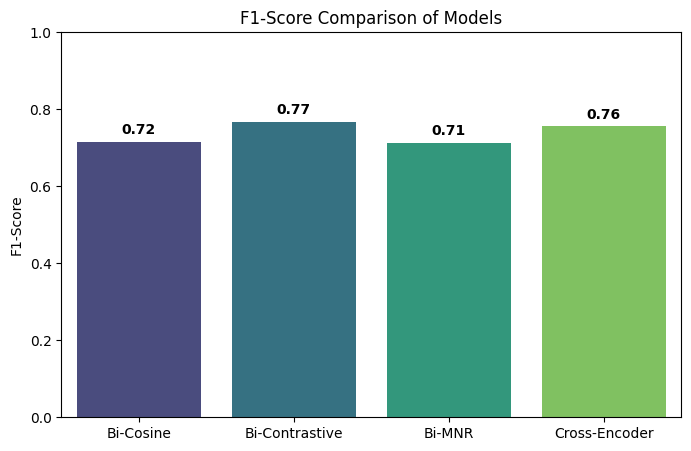

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect F1-scores
f1_scores = {
    "Bi-Cosine": evaluate_bi_model(bi_cos_model, test_df),
    "Bi-Contrastive": evaluate_bi_model(bi_contrastive_model, test_df),
    "Bi-MNR": evaluate_bi_model(bi_mnr_model, test_df),
    "Cross-Encoder": evaluate_cross_model(cross_model, test_df)
}

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")
plt.title("F1-Score Comparison of Models")
plt.ylabel("F1-Score")
plt.ylim(0,1)
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


In [ ]:
print(train_df['is_duplicate'].dtype)
print(train_df['is_duplicate'].unique())

int64
[0 1]
